In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import sys
#sys.path.append('/Users/dburns/Library/CloudStorage/Box-Box/my_scripts')
from ChACRA.ContactAnalysis.ContactFrequencies import *
import os
from ChACRA.ContactAnalysis.contact_functions import _parse_id
from ChACRA.ContactAnalysis.utils import *
from ChACRA.ContactAnalysis.contacts_to_pymol import to_pymol
%load_ext autoreload
%autoreload 2

In [2]:
#u = mda.Universe('/Users/dburns/Library/CloudStorage/Box-Box/1_GROUP_data/Enzymes/atcase/from_pronto/1q95/1q95_minimized_nohoh.pdb')
u = mda.Universe('../../../from_box/atcase/1q95_minimized_nohoh.pdb')
protein = u.select_atoms('protein')
u = mda.Merge(protein)
universe = u.copy()
residues = {seg.segid: seg.residues.resnames for seg in universe.segments}
segids = list(residues.keys())
# make a square matrix that will be filled with True values for identical subunits
array = np.zeros((len(segids),len(segids)),dtype=np.bool_)
# every subunit is identical with itself
np.fill_diagonal(array,True)
# work with it as a df
identical_table = pd.DataFrame(array, columns=segids, index=segids)

#contact_dir = '/Users/dburns/Library/CloudStorage/Box-Box/1_GROUP_data/Enzymes/atcase/from_nova/contacts/freqs'
contact_dir = '../../../from_box/atcase/freqs'
contact_files = [f'{contact_dir}/{file}' for file in os.listdir(contact_dir)]
contact_files.sort()
cont = make_contact_frequency_dictionary(contact_files)
cont = ContactFrequencies(pd.DataFrame(cont))

In [17]:
cont.contact_partners(53,81)

,B:THR:53-C:LEU:81,D:LEU:81-E:THR:53,A:LEU:81-C:THR:53,E:LEU:81-F:THR:53,D:THR:53-F:LEU:81,A:THR:53-B:LEU:81,L:ALA:81-L:MET:53
0,0.973,0.929,0.920,0.845,0.227,0.091,0.000
1,0.962,0.952,0.950,0.758,0.357,0.046,0.000
2,0.943,0.962,0.952,0.699,0.434,0.025,0.000
3,0.926,0.957,0.957,0.695,0.494,0.011,0.000
4,0.913,0.952,0.958,0.751,0.532,0.009,0.000
5,0.910,0.967,0.950,0.780,0.556,0.008,0.000
6,0.921,0.968,0.947,0.762,0.618,0.006,0.000
7,0.935,0.978,0.943,0.731,0.682,0.007,0.000
8,0.933,0.983,0.936,0.680,0.730,0.007,0.000
9,0.956,0.984,0.912,0.736,0.766,0.018,0.000


In [3]:
identical_subunits = find_identical_subunits(u)

In [4]:
sorted_distances = get_chain_distances(identical_subunits, u)

In [5]:
sorted_distances

{0: {('A', 'C'): 1.7065504023539435,
  ('A', 'B'): 1.7316963647164045,
  ('A', 'E'): 2.276290121014368,
  ('A', 'D'): 14.695149666859432,
  ('A', 'F'): 23.72274977485476},
 1: {('G', 'J'): 1.7411957335158068,
  ('G', 'I'): 27.48132477068823,
  ('G', 'H'): 28.549628162117425,
  ('G', 'K'): 30.40205853744378,
  ('G', 'L'): 44.52822064542099},
 (0, 1): {('A', 'G'): 1.6783015165014643,
  ('A', 'H'): 2.3374572559516813,
  ('A', 'K'): 10.352570156109394,
  ('A', 'I'): 11.368680308402194,
  ('A', 'J'): 19.089641017069628,
  ('A', 'L'): 27.828149816818694}}

In [6]:
sorted_all_chain_dists =  get_all_chain_dists(u)

In [9]:
sorted_all_chain_dists

{'F': {'L': 1.6868845940431783,
  'E': 1.6997656953686828,
  'D': 1.7251738858528087,
  'B': 1.8194105875476971,
  'K': 2.539416945533425,
  'H': 11.278661873099622,
  'J': 12.173696860953113,
  'C': 14.49427711966249,
  'I': 16.762685420723876,
  'A': 23.72274977485476,
  'G': 32.02890115513436},
 'B': {'C': 1.6813929744436025,
  'H': 1.6994563762386845,
  'A': 1.7316963647164045,
  'F': 1.8194105875476971,
  'I': 2.405174661796874,
  'L': 10.596713522639728,
  'G': 11.396500598235063,
  'E': 12.988872906635818,
  'K': 16.547568071963777,
  'D': 24.546360514064247,
  'J': 30.74457695856177},
 'A': {'G': 1.6783015165014643,
  'C': 1.7065504023539435,
  'B': 1.7316963647164045,
  'E': 2.276290121014368,
  'H': 2.3374572559516813,
  'K': 10.352570156109394,
  'I': 11.368680308402194,
  'D': 14.695149666859432,
  'J': 19.089641017069628,
  'F': 23.72274977485476,
  'L': 27.828149816818694},
 'I': {'C': 1.649130675274525,
  'L': 1.8766633250333378,
  'B': 2.405174661796874,
  'D': 10.76695

# calculate the distances between each chain and all others

### Use contact df to determine which chains actually make contact

In [7]:

df = cont.freqs
partner_chains = get_contacting_chains(df)

In [19]:
partner_chains

{'B': {'A', 'B', 'C', 'E', 'F', 'H', 'I'},
 'C': {'A', 'B', 'C', 'D', 'F', 'G', 'I', 'J'},
 'D': {'C', 'D', 'E', 'F', 'I', 'J', 'L'},
 'E': {'A', 'B', 'D', 'E', 'F', 'J', 'K'},
 'A': {'A', 'B', 'C', 'E', 'G', 'H'},
 'L': {'D', 'F', 'I', 'L'},
 'J': {'C', 'D', 'E', 'G', 'J'},
 'I': {'B', 'C', 'D', 'I', 'L'},
 'G': {'A', 'C', 'G', 'J'},
 'H': {'A', 'B', 'H', 'K'},
 'F': {'B', 'C', 'D', 'E', 'F', 'K', 'L'},
 'K': {'E', 'F', 'H', 'K'}}

# New Averaging Loop

In [ ]:
sorted_distances ## The distances between priority_subunit and the other subunits
                # dictionary keys are integer or tuples for inter-subunit data
segids  # the list of all the segids
sorted_all_chain_dists ## the minimum distances between the segid key and all other segments 
                # the other segments are in a nested dictionary holding their distances as values
partner_chains # the dictionary of segid keys and lists of all other segids it makes contact with from the contact df
identical_subunits # the dictionary containing lists of identical subunit segids
#angles # the angles between a list of contacting residues using the com as the vertex
#distances # the distances between a list of contacts 

In [18]:
equivalent_interactions.keys()

dict_keys([('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('A', 'I'), ('A', 'J'), ('A', 'K'), ('A', 'L'), ('B', 'G'), ('C', 'G'), ('D', 'G'), ('E', 'G'), ('F', 'G'), ('G', 'H'), ('G', 'I'), ('G', 'J'), ('G', 'K'), ('G', 'L')])

In [92]:
equivalent_interactions[('A','C')]

[('A', 'C'), ('A', 'B'), ('B', 'C'), ('D', 'E'), ('E', 'F'), ('D', 'F')]

# Averaging Loop

In [93]:
import tqdm

In [100]:

  
  

#TODO progress bar
#TODO figure out non redundant equivalent interactions and make that the denominator if the contact comes from that set
# For now can leave it equal to the minimum number of identical subunits involved in the contact 
#(if it's between non-identical subunits, choose the subunit that has fewer identical ones)
denominator = 6
df_copy = df.copy()
# hold the averaged data
averaged_data = {}
# select one of each type of chain to be the representative chain for average naming
representative_chains = ['A', 'G']
# determine what the equivalent chain interactions relative to representative chains are for all the subunits
print("Finding interactions equivalent to those involving representative_chains.")
equivalent_interactions = get_equivalent_interactions(representative_chains,u)
# Retrieve/assign these from sorted identical subunits first indices.... although we want the other identical subunits first index to neighbor the chain in
# the first set... A needs to be next to G... This is the case for ATCASE - can just edit the chains in the PDB.... and produce a PDB for visualization along with averaging...
# identify priority name from each set of identical subunits

print('Collecting identical contacts and averaging.')
total_count = len(df.columns)
with tqdm.tqdm(total=total_count) as progress:

     while len(df_copy.columns) > 0:
          resids = _parse_id(df_copy.columns[0])

          # find all of the other contacts that involve these residue names and numbers
          # intersubunit contacts can have swapped resids
          # so search with both regexes 
     
          regex = make_equivalent_contact_regex(resids)
          to_average = list(df_copy.filter(regex=regex, axis=1).columns)
          # now filter these to ensure you're only taking ones with equivalent_interaction names
          # chains should always be in alphabetical order
          chaina, chainb = resids['chaina'], resids['chainb']
          
          if chaina == chainb:
               identical_pair = True
          else:
               identical_pair = False

          representative_pair = get_representative_pair_name(chaina, chainb, identical_subunits, representative_chains, equivalent_interactions)
     


          
          # Can't deal the same with things ivolving a single subunit because not accounting for it in equivalent_interactions
          if identical_pair:
               averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
               to_drop = []
               for contact_name in to_average:
                    contact_info = _parse_id(contact_name)
                    # the chain equivalency check isn't necessary
                    # but if if the chaina variable isn't in the same identical subunit group as the current contact's chain
                    # drop it (that means it's happens to have the same resname and resnum but is happening on a different kind of subunit)
                    if (contact_info['chaina'] not in identical_subunits[get_chain_group(chaina, identical_subunits)]):
                         to_drop.append(contact_name)
               for contact_name in to_drop:
                    to_average.remove(contact_name)

          else:
               # if they're not identical and the first representative pair member matches is from the same identical subunit set as chaina
               # this only works for inter-hetero-subunit contacts NOT for inter-homo-subunit

               # inter-homo-subunit then need to first drop everything that involves the hetero-subunit
               to_drop = []
               resnums = []
               matched_name = None
               #REMOVE
               #flipped = None
               for contact_name in to_average:
                    contact_info = _parse_id(contact_name)
                    if (contact_info['chaina'],contact_info['chainb']) not in equivalent_interactions[representative_pair]:
                         to_drop.append(contact_name)
                    # else: 
                    #     # use this to identify the outlier that would give a flipped naming scheme
                    #    resnums.append(contact_info['resida'])
                         
                    if (contact_info['chaina'], contact_info['chainb']) == representative_pair:
                         matched_name = contact_name
                         # this doesn't make sense, comparing resids to chainids REMOVE
                         #elif (contact_info['residb'], contact_info['resida']) == representative_pair:
                              #flipped = True


               # drop the ones that don't fit the original pair
               for contact_name in to_drop:
                    to_average.remove(contact_name)


               # if inter-hetero subunit     
               if get_chain_group(representative_pair[0], identical_subunits) != get_chain_group(representative_pair[1], identical_subunits):
                    # and the order of the hetero subunit matches the representative_pairs, you can name it without further consideration 
                    if get_chain_group(representative_pair[0], identical_subunits) ==  get_chain_group(resids['chaina'], identical_subunits):
                         averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                    # else:
                    #      averaged_name =  f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
               # it's inter-homo subunit
               else:
                    # this should be the only case where you have to guess.. 
                    # if the contact chains are the same as the representative pair, you eliminate one situation
                    if matched_name is not None:
                         averaged_name = matched_name
                    # elif flipped is not None:
                    #      averaged_name = f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
                    else:
                         #measure the distance between the contacting residues for each contact
                         # can probably move this to top of the parent else (3rd back) when it originally iterates over to_average.  
                         contact_distances = []
                         for contact_name in to_average:
                              contact_info = _parse_id(contact_name)
                              sel1 = f"chainID {contact_info['chaina']} and resnum {contact_info['resida']} and name CA"
                              sel2 = f"chainID {contact_info['chainb']} and resnum {contact_info['residb']} and name CA"
                              contact_distances.append(get_pair_distance(sel1, sel2, u))

                         mean_distance = np.mean(contact_distances)

                         testa1 = f"chainID {representative_pair[0]} and resnum {contact_info['resida']} and name CA"
                         testa2 = f"chainID {representative_pair[1]} and resnum {contact_info['residb']} and name CA"
                         testb1 = f"chainID {representative_pair[1]} and resnum {contact_info['resida']} and name CA"
                         testb2 = f"chainID {representative_pair[0]} and resnum {contact_info['residb']} and name CA"

                         testa = get_pair_distance(testa1, testa2, u)
                         testb = get_pair_distance(testb1, testb2, u)
                         
                         # if the difference between the mean contact distance distance and the chain swapped one is greater....
                         if np.abs(testa-mean_distance) < np.abs(testb-mean_distance):
                              averaged_name = f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                         else:
                              # TODO Fix bad swap
                              averaged_name =  f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
                         # now get both distances for the representative pair with resids swapped 
                         # and take the name that has the distance most closely matching the mean.
                         #compare_distances between the resids (and possibly all the others to get avg dist) and then the representative_pair and flipped representative_pair

          #  denominator = len(longest_identical_chain_group participating in intersubunit contact)
          # TODO denominator needs to be cut in half if separate identical chains are making contact between the same resid
          averaged_data[averaged_name] = df_copy[to_average].sum(axis=1)/denominator
          df_copy.drop(to_average, axis=1, inplace=True)
          columns_removed = len(to_average)
          progress.update(columns_removed)
          

Finding interactions equivalent to those involving representative_chains.


100%|██████████| 31554/31554 [00:37<00:00, 840.27it/s] 


## Averaging Function

In [103]:
def average_multimer(structure, denominator, df, representative_chains):
     '''

     

     select one of each type of chain to be the representative chain for average naming
     '''

     u = mda.Universe(structure)
     #TODO figure out non redundant equivalent interactions and make that the denominator if the contact comes from that set
     # For now can leave it equal to the minimum number of identical subunits involved in the contact 
     #(if it's between non-identical subunits, choose the subunit that has fewer identical ones)
     denominator = 6
     df_copy = df.copy()
     # hold the averaged data
     averaged_data = {}
  
     # determine what the equivalent chain interactions relative to representative chains are for all the subunits
     print("Finding interactions equivalent to those involving representative_chains. One moment.")
     equivalent_interactions = get_equivalent_interactions(representative_chains,u)
     
     print('Collecting equivalent contacts and averaging.')
     total_count = len(df.columns)
     with tqdm.tqdm(total=total_count) as progress:

          while len(df_copy.columns) > 0:
               resids = _parse_id(df_copy.columns[0])

               # find all of the other contacts that involve these residue names and numbers
               regex = make_equivalent_contact_regex(resids)
               to_average = list(df_copy.filter(regex=regex, axis=1).columns)
               # chaina and chainb are picked up from this iterations initial contact 
               chaina, chainb = resids['chaina'], resids['chainb']
               if chaina == chainb:
                    identical_pair = True
               else:
                    identical_pair = False
               # get the chain id pair that the averaged name will be based on
               # can't determine the averaged name yet because inter-subunit contacts can have flipped resids (A-> B can be equivalent to C->A but this is recorded as A->C 
               # but the resids are swapped)
               representative_pair = get_representative_pair_name(chaina, chainb, identical_subunits, representative_chains, equivalent_interactions)

               ######################################### Determine Average Contact Name and Filter out things that shouldn't be in to_average ###########
               ####################################### Happening in same subunit ##############################################################
               if identical_pair:
                    # The easiest (and most common) case
                    averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                    to_drop = []
                    for contact_name in to_average:
                         contact_info = _parse_id(contact_name)
                         # if the chaina variable isn't in the same identical subunit group as the current contact's chain you know it's wrong
                         # drop it (this means it happens to have the same resname and resnum but is happening on a different kind of subunit - very unlikely)
                         if (contact_info['chaina'] not in identical_subunits[get_chain_group(chaina, identical_subunits)]):
                              to_drop.append(contact_name)
                    for contact_name in to_drop:
                         to_average.remove(contact_name)
               ##################################### Happening Inter-Subunit ########################################################
               else:
                    # filter and catch the averaged_name if it's in to_average
                    to_drop = []
                    matched_name = None
                    
                    for contact_name in to_average:
                         contact_info = _parse_id(contact_name)
                         # drop everything that's not from the equivalent_interaction set
                         if (contact_info['chaina'],contact_info['chainb']) not in equivalent_interactions[representative_pair]:
                              to_drop.append(contact_name)
                         # if one of to_average involves both of representative_pair's chains, then the name is determined    
                         if (contact_info['chaina'], contact_info['chainb']) == representative_pair:
                              matched_name = contact_name

                    # drop the ones that don't fit the original pair
                    for contact_name in to_drop:
                         to_average.remove(contact_name)


                    # if inter-hetero subunit     
                    if get_chain_group(representative_pair[0], identical_subunits) != get_chain_group(representative_pair[1], identical_subunits):
                         # and the order that the hetero subunit appears in representative_pairs matches, you can name it without further consideration 
                         if get_chain_group(representative_pair[0], identical_subunits) ==  get_chain_group(resids['chaina'], identical_subunits):
                              averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                    else: 
                         # if a contact was found earlier that matches the representative pair, you name it now
                         if matched_name is not None:
                              averaged_name = matched_name

                         else:
                              # have to determine if the original contact for this iteration happens to have the flipped inter-subunit naming
                              # and to_average didn't include the contact with the representative naming scheme (should not happen often)

                              # so we measure the distance between the contacting residues for each contact and determine the distance that these residues should be apart
                              # and then test the representative_pair residue distances with the default name and with the flipped resid info
                              ################# measure each distance in to_average's contacts ##################################
                              contact_distances = []
                              for contact_name in to_average:
                                   contact_info = _parse_id(contact_name)
                                   sel1 = f"chainID {contact_info['chaina']} and resnum {contact_info['resida']} and name CA"
                                   sel2 = f"chainID {contact_info['chainb']} and resnum {contact_info['residb']} and name CA"
                                   contact_distances.append(get_pair_distance(sel1, sel2, u))

                              #### identify the correct contact averaged_name by checking the two possible distances ########################
                              mean_distance = np.mean(contact_distances)

                              testa1 = f"chainID {representative_pair[0]} and resnum {contact_info['resida']} and name CA"
                              testa2 = f"chainID {representative_pair[1]} and resnum {contact_info['residb']} and name CA"
                              testb1 = f"chainID {representative_pair[1]} and resnum {contact_info['resida']} and name CA"
                              testb2 = f"chainID {representative_pair[0]} and resnum {contact_info['residb']} and name CA"

                              testa = get_pair_distance(testa1, testa2, u)
                              testb = get_pair_distance(testb1, testb2, u)
                              
                              # if the difference between the mean contact distance distance and the chain swapped one is greater....
                              if np.abs(testa-mean_distance) < np.abs(testb-mean_distance):
                                   averaged_name = f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                              else:
                                   averaged_name =  f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
                              ##################################### End flipped contact name adjustment ##########################################################################
               ################################ End inter-subunit #####################################################################################
               #  denominator = len(longest_identical_chain_group participating in intersubunit contact)
               # TODO denominator needs to be cut in half if separate identical chains are making contact between the same resid and they're 180 deg to one another based off the entire complex com
               averaged_data[averaged_name] = df_copy[to_average].sum(axis=1)/denominator

               # get rid of the contacts that were just averaged and reduce the number of remaining contacts to check in the dataframe
               df_copy.drop(to_average, axis=1, inplace=True)
               # update the progress bar
               columns_removed = len(to_average)
               progress.update(columns_removed)

     return pd.DataFrame(averaged_data)
          

In [106]:
structure = '../../../from_box/atcase/1q95_minimized_nohoh.pdb'
avg_df = average_multimer(structure, 6, df, ['A','G'])

Finding interactions equivalent to those involving representative_chains.


100%|██████████| 31554/31554 [00:37<00:00, 838.44it/s] 


In [107]:
avg_df

,A:ALA:112-A:ASN:126,A:GLN:146-A:LEU:152,A:THR:26-A:VAL:309,A:LEU:192-A:PRO:189,A:ARG:65-A:GLN:297,A:ARG:56-A:SER:74,A:ARG:105-A:PHE:49,A:ALA:175-A:PHE:179,A:GLU:60-A:SER:62,G:ASP:19-G:PHE:65,...,A:TYR:98-C:PHE:294,G:CYS:141-G:GLU:144,G:THR:82-G:VAL:9,A:ALA:274-A:ILE:273,G:GLU:68-G:LEU:99,A:LEU:254-A:VAL:160,A:ASN:256-A:HIS:282,A:ASN:13-G:CYS:138,A:ASP:278-A:MET:227,A:GLU:109-G:GLU:119
0,0.427167,0.477833,0.239167,0.996667,0.685167,0.924000,0.999000,0.869333,0.999833,0.044000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.431500,0.487000,0.249667,0.997667,0.685500,0.915333,0.998833,0.869000,0.999500,0.051833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.438167,0.483167,0.258167,0.997500,0.688000,0.908667,0.999000,0.868333,0.999500,0.060333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.440833,0.482000,0.273500,0.997333,0.687500,0.902667,0.998333,0.866167,0.999167,0.055333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.431667,0.482500,0.288667,0.997167,0.681167,0.900333,0.998500,0.862667,0.999667,0.051167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.431000,0.480667,0.294500,0.997333,0.681500,0.893167,0.998500,0.859000,0.999167,0.044167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.436000,0.469000,0.294833,0.997500,0.680333,0.889000,0.998333,0.854833,0.999167,0.036167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.456500,0.470833,0.305000,0.996500,0.675667,0.890500,0.998333,0.849667,0.999500,0.029000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.475500,0.473500,0.309500,0.997167,0.671333,0.886333,0.998000,0.840333,0.998833,0.023833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.485667,0.465500,0.320333,0.997167,0.673167,0.883667,0.997833,0.836667,0.999000,0.022333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
matched_name = None
matched_name 

In [28]:
avg

,A:ALA:112-A:ASN:126,A:GLN:146-A:LEU:152,A:THR:26-A:VAL:309,A:LEU:192-A:PRO:189,A:ARG:65-A:GLN:297,A:ARG:56-A:SER:74,A:ARG:105-A:PHE:49,A:ALA:175-A:PHE:179,A:GLU:60-A:SER:62,G:ASP:19-G:PHE:65,...,A:TYR:98-C:PHE:294,G:CYS:141-G:GLU:144,G:THR:82-G:VAL:9,A:ALA:274-A:ILE:273,G:GLU:68-G:LEU:99,A:LEU:254-A:VAL:160,A:ASN:256-A:HIS:282,A:ASN:13-G:CYS:138,A:ASP:278-A:MET:227,A:GLU:109-G:GLU:119
0,0.427167,0.477833,0.239167,0.996667,0.685167,0.924000,0.999000,0.869333,0.999833,0.044000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.431500,0.487000,0.249667,0.997667,0.685500,0.915333,0.998833,0.869000,0.999500,0.051833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.438167,0.483167,0.258167,0.997500,0.688000,0.908667,0.999000,0.868333,0.999500,0.060333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.440833,0.482000,0.273500,0.997333,0.687500,0.902667,0.998333,0.866167,0.999167,0.055333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.431667,0.482500,0.288667,0.997167,0.681167,0.900333,0.998500,0.862667,0.999667,0.051167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.431000,0.480667,0.294500,0.997333,0.681500,0.893167,0.998500,0.859000,0.999167,0.044167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.436000,0.469000,0.294833,0.997500,0.680333,0.889000,0.998333,0.854833,0.999167,0.036167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.456500,0.470833,0.305000,0.996500,0.675667,0.890500,0.998333,0.849667,0.999500,0.029000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.475500,0.473500,0.309500,0.997167,0.671333,0.886333,0.998000,0.840333,0.998833,0.023833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.485667,0.465500,0.320333,0.997167,0.673167,0.883667,0.997833,0.836667,0.999000,0.022333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
cpca = ContactPCA(avg)

Opening the chacras.


In [30]:
cpca.sorted_norm_loadings(2)[:20]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
A:THR:87-A:THR:91,0.123827,1.000000,0.114016,0.671984,0.102455,0.439172,0.486314,0.318474,0.655025,0.309997,...,0.290452,0.325163,0.631013,0.300665,0.116687,0.016762,0.075521,0.281354,0.333331,0.251684
A:ASP:90-A:THR:87,0.145567,0.813350,0.140293,0.369683,0.026958,0.321256,0.011768,0.074156,0.700283,0.330572,...,0.010155,0.260851,0.328045,0.042109,0.066112,0.330179,0.024089,0.204127,0.117403,0.079194
A:ASN:291-A:PHE:143,0.125328,0.702889,0.093059,0.287826,0.109090,0.269536,0.158369,0.284048,0.254494,0.052754,...,0.069345,0.173618,0.000136,0.248822,0.014200,0.112542,0.280631,0.434286,0.225031,0.055135
A:LYS:84-C:PRO:268,0.249094,0.642036,0.474715,0.070186,0.108887,0.370018,0.430640,0.027904,0.247114,0.057375,...,0.477547,0.294899,0.089071,0.149614,0.104865,0.229013,0.359245,0.121339,0.077211,0.224255
A:GLU:86-A:THR:91,0.315589,0.635350,0.051773,0.034115,0.234893,0.436523,0.206834,0.115715,0.630829,0.216409,...,0.028413,0.139986,0.096318,0.182170,0.138451,0.084867,0.337356,0.187021,0.156575,0.054653
A:GLU:86-A:SER:80,0.440931,0.614614,0.001322,0.188383,0.061336,0.057468,0.155487,0.178560,0.450308,0.070020,...,0.064175,0.389967,0.207464,0.143368,0.164379,0.539199,0.142869,0.301103,0.028808,0.013319
A:ALA:289-A:ASN:291,0.033843,0.611732,0.639855,0.127412,0.080487,0.047898,0.331656,0.301891,0.217676,0.246282,...,0.011710,0.220475,0.005982,0.210723,0.022654,0.193634,0.258112,0.217004,0.313456,0.538344
A:GLN:288-A:LEU:140,0.127836,0.605662,0.492403,0.324809,0.002989,0.199855,0.136371,0.163228,0.094040,0.327766,...,0.252495,0.438977,0.296614,0.354157,0.183941,0.468265,0.300550,0.710309,0.114185,0.649709
A:ARG:296-A:GLY:292,0.014862,0.600618,0.398647,0.403522,0.155229,0.048346,0.191367,0.290047,0.640579,0.096856,...,0.038812,0.308131,0.039209,0.218958,0.052158,0.213894,0.078854,0.001182,0.283879,0.587971
A:LEU:81-C:THR:53,0.284743,0.596876,0.023518,0.301066,0.160019,0.064114,0.239023,0.051736,0.209419,0.145894,...,0.007271,0.085380,0.104040,0.164418,0.294156,0.143178,0.074642,0.047851,0.040277,0.371634


In [35]:
cpca.sorted_loadings(2).loc['A:LEU:81-C:THR:53']

PC1     0.032755
PC2    -0.084165
PC3    -0.002367
PC4     0.035038
PC5     0.017420
PC6     0.006112
PC7    -0.022770
PC8     0.007042
PC9    -0.017853
PC10    0.017185
PC11   -0.033773
PC12   -0.007124
PC13    0.000222
PC14   -0.032446
PC15   -0.001393
PC16    0.024667
PC17   -0.009386
PC18   -0.005470
PC19   -0.018494
PC20   -0.036109
PC21   -0.001029
PC22   -0.028263
PC23    0.000713
PC24   -0.008116
PC25   -0.011497
PC26   -0.015942
PC27   -0.027741
PC28    0.013579
PC29   -0.005694
PC30   -0.003628
PC31   -0.003693
PC32    0.030557
Name: A:LEU:81-C:THR:53, dtype: float64

In [36]:
avg_cont = ContactFrequencies(avg)

In [87]:
to_visualize = []
for i in range(1,9):
    to_visualize.extend(cpca.sorted_norm_loadings(i).index[:20])


In [88]:
from ChACRA.ContactAnalysis.contacts_to_pymol import to_pymol

to_pymol(to_visualize,avg_cont,cpca,
    f'/home/kanaka/from_box/atcase/chacras_8.pml',pc_range=(1,8))

In [39]:
#cpca.permutated_explained_variance(avg, 500)

This can take a moment. Progress updates every 10 iterations.
0..10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..

In [ ]:
# functions to make averaged network across entire protein
# depict averaged chacras on entire protein
# 
def generate_equivalent_contact(contact, equivalent_interactions, u):
    '''
    Take an averaged contact and generate it on the identical subunit pair.
    This lets you map averaged contacts back onto the whole protein for visualizing
    or creating a network.
    '''


In [64]:
cpca.sorted_norm_loadings(1)['PC1'].values

array([1.        , 0.86594886, 0.82646742, ..., 0.        , 0.        ,
       0.        ])

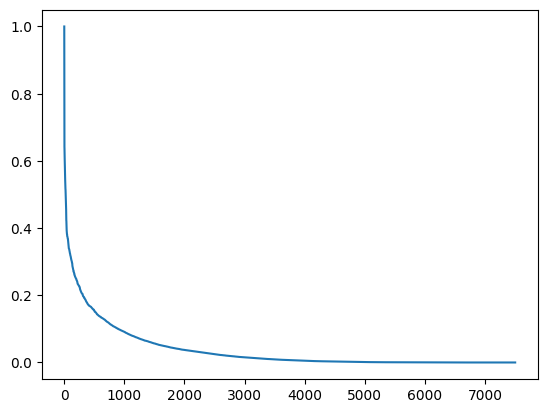

In [67]:
plt.plot(cpca.sorted_norm_loadings(2)['PC2'].values)

In [49]:
pca = PCA()
pca.fit(avg)
pcs=pca.transform(avg)
original_variance = pca.explained_variance_ratio_

variance = cpca._permutated_explained_variance

In [52]:
N_permutations = 500

In [54]:
import matplotlib.pyplot as plt

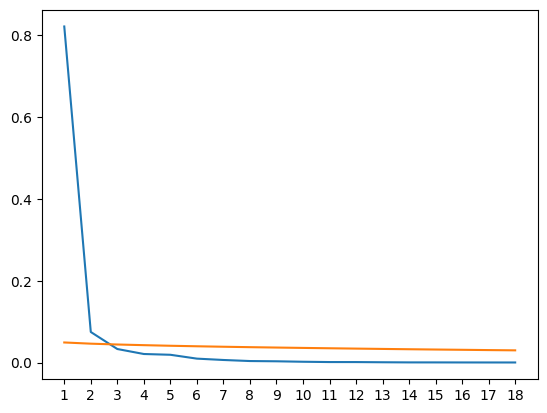

In [61]:
average_permuted_variance = np.mean(variance, axis=0)

plt.plot([f'{i+1}' for i in range(len(df.index[:18]))],original_variance[:18], label='Explained Variance')
plt.plot([f'{i+1}' for i in range(len(df.index[:18]))],average_permuted_variance[:18], label='Explained by Chance')

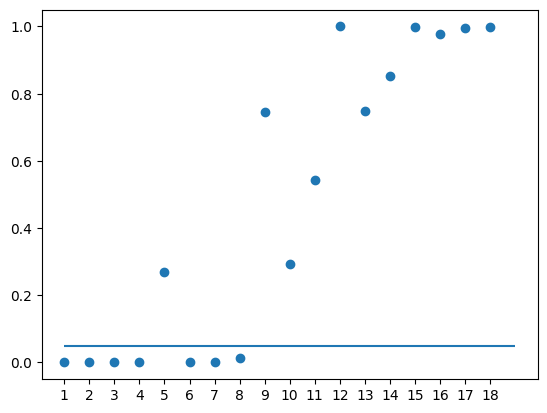

In [55]:
# difference of roots
p_val = np.sum(np.abs(np.diff(variance, axis=1, prepend=0)) > \
               np.abs(np.diff(original_variance, prepend=0)), axis=0) / N_permutations

#fig, ax = plt.subplots()
#fig.figsize((10,8))
#plt.figure(figsize=(20,8))
plt.scatter([f'{i+1}' for i in range(18)], p_val[:18], label='p-value on significance')
plt.hlines(.05,xmin=0,xmax=18)

<BarContainer object of 32 artists>

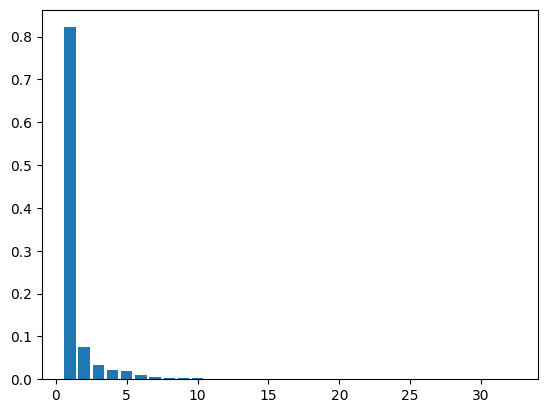

In [57]:
plt.bar(x=range(1,33),height=pca.explained_variance_ratio_)

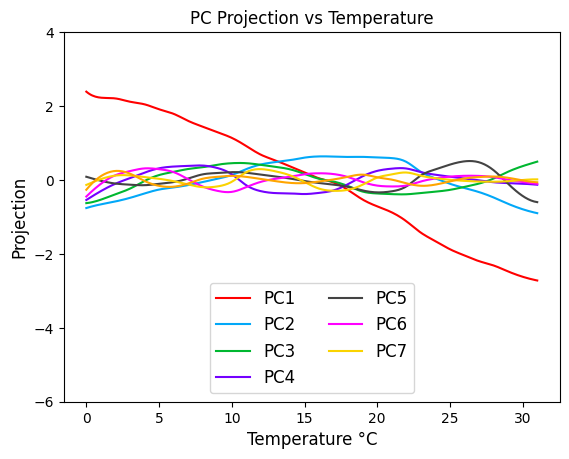

In [60]:
from scipy.interpolate import make_interp_spline


colors = ['red','#02a8f8','#00b730','#7400ff','#434343','magenta','#fad300','orange']
x = np.array(avg.index)

for pc in range(1,9):
 
    y = pcs[:,pc-1]

    X_Y_Spline = make_interp_spline(x, y)

    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 300)
    Y_ = X_Y_Spline(X_)
    
    # Plotting the Graph
    plt.ylim((-6,4))
    plt.plot(X_, -1*Y_,color=colors[pc-1])
plt.title(f'PC Projection vs Temperature')
plt.xlabel("Temperature °C", fontsize=12)
plt.ylabel("Projection", fontsize=12)
#plt.vlines(x=373,ymin=0,ymax=.84,linestyles='dotted')
plt.legend([f'PC{i}' for i in range(1,8)], fontsize=12, loc='lower center', ncol=2)